# fbb skeleton notebook for PUI2017 HW6

In [1]:
from __future__ import print_function, division
import numpy as np
import geopandas as gp   
import pandas as pd
import matplotlib.pylab as pl

import os
import json
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

import io
import zipfile
import statsmodels.formula.api as smf
import statsmodels.api as sm

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [2]:
#Load CSV file to get nrg data
def getCSV(url, saved=False, **kwargs):
    cache_name = os.path.basename(url)
    csv_file = os.path.join(os.getenv('PUIDATA', './'), cache_name)
    
    if os.path.isfile(csv_file) and not saved:
        print('Loading from:', csv_file)
        return gp.GeoDataFrame.from_csv(csv_file) 
    else:
        print('Not in PUIDATA. Loading from url.')
        df = gp.GeoDataFrame.from_csv(urllib.urlopen(url), **kwargs)

        # Save dataframe as cached 
        df.to_csv(csv_file, index=False)
    return df

In [3]:
nrg = getCSV(
    'https://data.cityofnewyork.us/resource/m46j-75iy.csv', saved=True)
nrg.head()

Not in PUIDATA. Loading from url.


,bbls_co_reported,bin,borough,census_tract,co_reported_bbl_status,community_board,community_council,direct_ghg_emissions_mtco2e,dof_benchmarking_submission_status,dof_number_of_buildings,...,reported_property_floor_area_building_s_ft,reported_water_method,site_eui_kbtu_ft2,source_eui_kbtu_ft2,street_name,street_number,total_ghg_emissions_mtco2e,weather_normalized_site_eui_kbtu_ft2,weather_normalized_source_eui_kbtu_ft2,zip_code
automatic_water_benchmarking_eligible,,,,,,,,,,,,,,,,,,,,,
NaN,1000410001,NaN,Manhattan,NaN,NaN,NaN,NaN,NaN,BBL not valid,NaN,...,918919,NaN,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
Yes,NaN,NaN,Queens,NaN,NaN,NaN,NaN,NaN,No Submission Matched to BBL,1.0,...,NaN,None,NaN,NaN,108 STREET,63-10,NaN,NaN,NaN,11375.0
NaN,2027620097,NaN,Bronx,NaN,NaN,NaN,NaN,NaN,BBL not valid,NaN,...,64200,NaN,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
No,NaN,1012266.0,Manhattan,99.0,NaN,4.0,3.0,NaN,No Submission Matched to BBL,1.0,...,NaN,None,NaN,NaN,11 AVENUE,201,NaN,NaN,NaN,10001.0
NaN,2048300034,NaN,Bronx,NaN,NaN,NaN,NaN,NaN,Not on Covered Buildings List,NaN,...,50000,None,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN


In [4]:
nrg.size

31000

In [5]:
nrg.columns

Index(['bbls_co_reported', 'bin', 'borough', 'census_tract',
       'co_reported_bbl_status', 'community_board', 'community_council',
       'direct_ghg_emissions_mtco2e', 'dof_benchmarking_submission_status',
       'dof_number_of_buildings',
       'dof_property_floor_area_buildngs_and_parking_ft2', 'energy_star_score',
       'indirect_ghg_emissions_mtco2e', 'latitude', 'longitude',
       'municipally_supplied_potable_water_indoor_intensity_gal_ft', 'nta',
       'nyc_borough_block_and_lot_bbl', 'primary_property_type_self_selected',
       'record_number', 'reported_nyc_building_identificaiton_numbers_bins',
       'reported_property_floor_area_building_s_ft', 'reported_water_method',
       'site_eui_kbtu_ft2', 'source_eui_kbtu_ft2', 'street_name',
       'street_number', 'total_ghg_emissions_mtco2e',
       'weather_normalized_site_eui_kbtu_ft2',
       'weather_normalized_source_eui_kbtu_ft2', 'zip_code'],
      dtype='object')

In [6]:
#Using this way to get the data to just show a second way of getting the data
PUIdata = os.getenv('PUIDATA')
print (PUIdata)
#loading the zip file from pluto

if not os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
    print('Downloading...')
    os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip')
    os.system('mv nyc_pluto_16v2%20.zip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/nyc_pluto_16v2%20.zip -d ' + PUIdata)
    if os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
        print('File present, proceed!')
else:
    print('File present, proceed!')

/home/cusp/vmr286/PUIdata
Downloading...
File present, proceed!


In [7]:
#saving the shapefile in bsize
bsize = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/BORO_zip_files_csv/MN.csv")

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
bsize.columns

Index(['Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist', 'Council',
       'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea', 'SanitBoro',
       'SanitDistrict', 'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2',
       'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2',
       'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse',
       'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea', 'ComArea',
       'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea',
       'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs', 'NumFloors',
       'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth', 'BldgFront',
       'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode',
       'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot', 'YearBuilt',
       'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark', 'BuiltFAR',
       'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL', 'CondoNo',
       'Tract2010', 'XCoord', 'YCoord', 'ZoneM

In [9]:
# make sure you clean up your data and throw away columns you do not need!

nrg_drop = nrg[['nyc_borough_block_and_lot_bbl', 'site_eui_kbtu_ft2', 'reported_property_floor_area_building_s_ft', 
'dof_property_floor_area_buildngs_and_parking_ft2', 'dof_number_of_buildings', 'zip_code']]

nrg_drop.head()

,nyc_borough_block_and_lot_bbl,site_eui_kbtu_ft2,reported_property_floor_area_building_s_ft,dof_property_floor_area_buildngs_and_parking_ft2,dof_number_of_buildings,zip_code
automatic_water_benchmarking_eligible,,,,,,
NaN,1.000410e+09,NaN,918919,NaN,NaN,NaN
Yes,4.021460e+09,NaN,NaN,82730.0,1.0,11375.0
NaN,2.027620e+09,NaN,64200,NaN,NaN,NaN
No,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0
NaN,2.048300e+09,NaN,50000,NaN,NaN,NaN


In [10]:
nrg_drop.size

6000

In [11]:
bsize_drop = bsize[['BBL', 'UnitsRes', 'UnitsTotal', 'YearBuilt']]

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

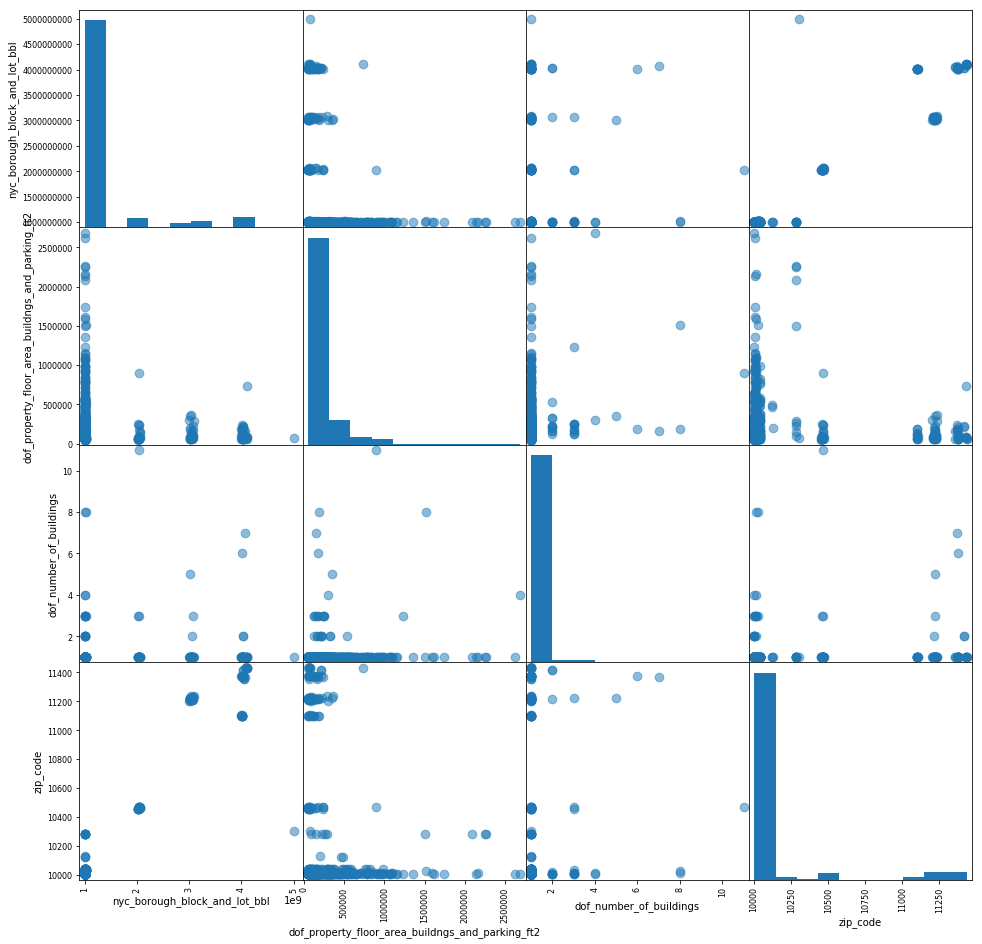

In [12]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg_drop, s=300, figsize=(16, 16));


Figure 1: The above figure is scatter matrix of all numerical values in the files. There are no obvious strong relationships in the data. The categorical variables - postcode and BBL are mistakenly treated as numerical variable. The other numberal variable - DOF number of buildings and the DOF property floor area, doesn't provide any meaningful information/analysis. The relevant columns like u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and u'Reported Property Floor Area (Building(s)) (ft²)', which is a measure of buildigs area, doesn't get plotted as they have string values mixed with float values in them. Therefore, it is important to remove all values that cannot be converted to float to be able to use these columns, and transform values to float arrays to performs tasks on them.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

In [13]:
nrg_drop['site_eui_kbtu_ft2']= pd.to_numeric(nrg['site_eui_kbtu_ft2'], errors='coerce')
nrg_drop['reported_property_floor_area_building_s_ft']= pd.to_numeric(nrg['reported_property_floor_area_building_s_ft'], errors='coerce')

nrg_drop.size


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


6000

In [14]:
#How many missing values?
indx = np.isnan(nrg_drop['site_eui_kbtu_ft2']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))

indx1 = np.isnan(nrg_drop['reported_property_floor_area_building_s_ft']).sum()
print ("invalid entries changed to NaN %d"%sum(indx1))
#do it for however many columns you need

nrg_drop.size

invalid entries changed to NaN 176
invalid entries changed to NaN 58


6000

** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [15]:
#rename the column name
nrg_drop=nrg_drop.rename(columns = {'nyc_borough_block_and_lot_bbl':'BBL'})
nrg_drop.head()

,BBL,site_eui_kbtu_ft2,reported_property_floor_area_building_s_ft,dof_property_floor_area_buildngs_and_parking_ft2,dof_number_of_buildings,zip_code
automatic_water_benchmarking_eligible,,,,,,
NaN,1.000410e+09,NaN,918919.0,NaN,NaN,NaN
Yes,4.021460e+09,NaN,NaN,82730.0,1.0,11375.0
NaN,2.027620e+09,NaN,64200.0,NaN,NaN,NaN
No,1.006700e+09,NaN,NaN,440360.0,1.0,10001.0
NaN,2.048300e+09,NaN,50000.0,NaN,NaN,NaN


In [16]:
(bsize_drop.BBL.values[0]), (nrg_drop.BBL.values[0])


(1000010010.0, 1000410001.0)

In [17]:
nrg_drop.size

6000

In [18]:
bsize_drop.size

171832

In [19]:
#merge the dataset on BBL
bblnrgdata = pd.merge(nrg_drop, bsize_drop, on='BBL').dropna()
bblnrgdata.shape

(687, 9)

In [20]:
bblnrgdata.head()

,BBL,site_eui_kbtu_ft2,reported_property_floor_area_building_s_ft,dof_property_floor_area_buildngs_and_parking_ft2,dof_number_of_buildings,zip_code,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,330000.0,313200.0,1.0,10022.0,0,56,1977
15,1.007660e+09,122.3,59468.0,53168.0,1.0,10011.0,0,8,1912
16,1.008150e+09,117.0,364000.0,364000.0,1.0,10018.0,0,24,1954
18,1.005050e+09,82.1,235370.0,214110.0,1.0,10013.0,0,24,1926
19,1.021420e+09,137.7,64806.0,64816.0,1.0,10032.0,54,62,1924


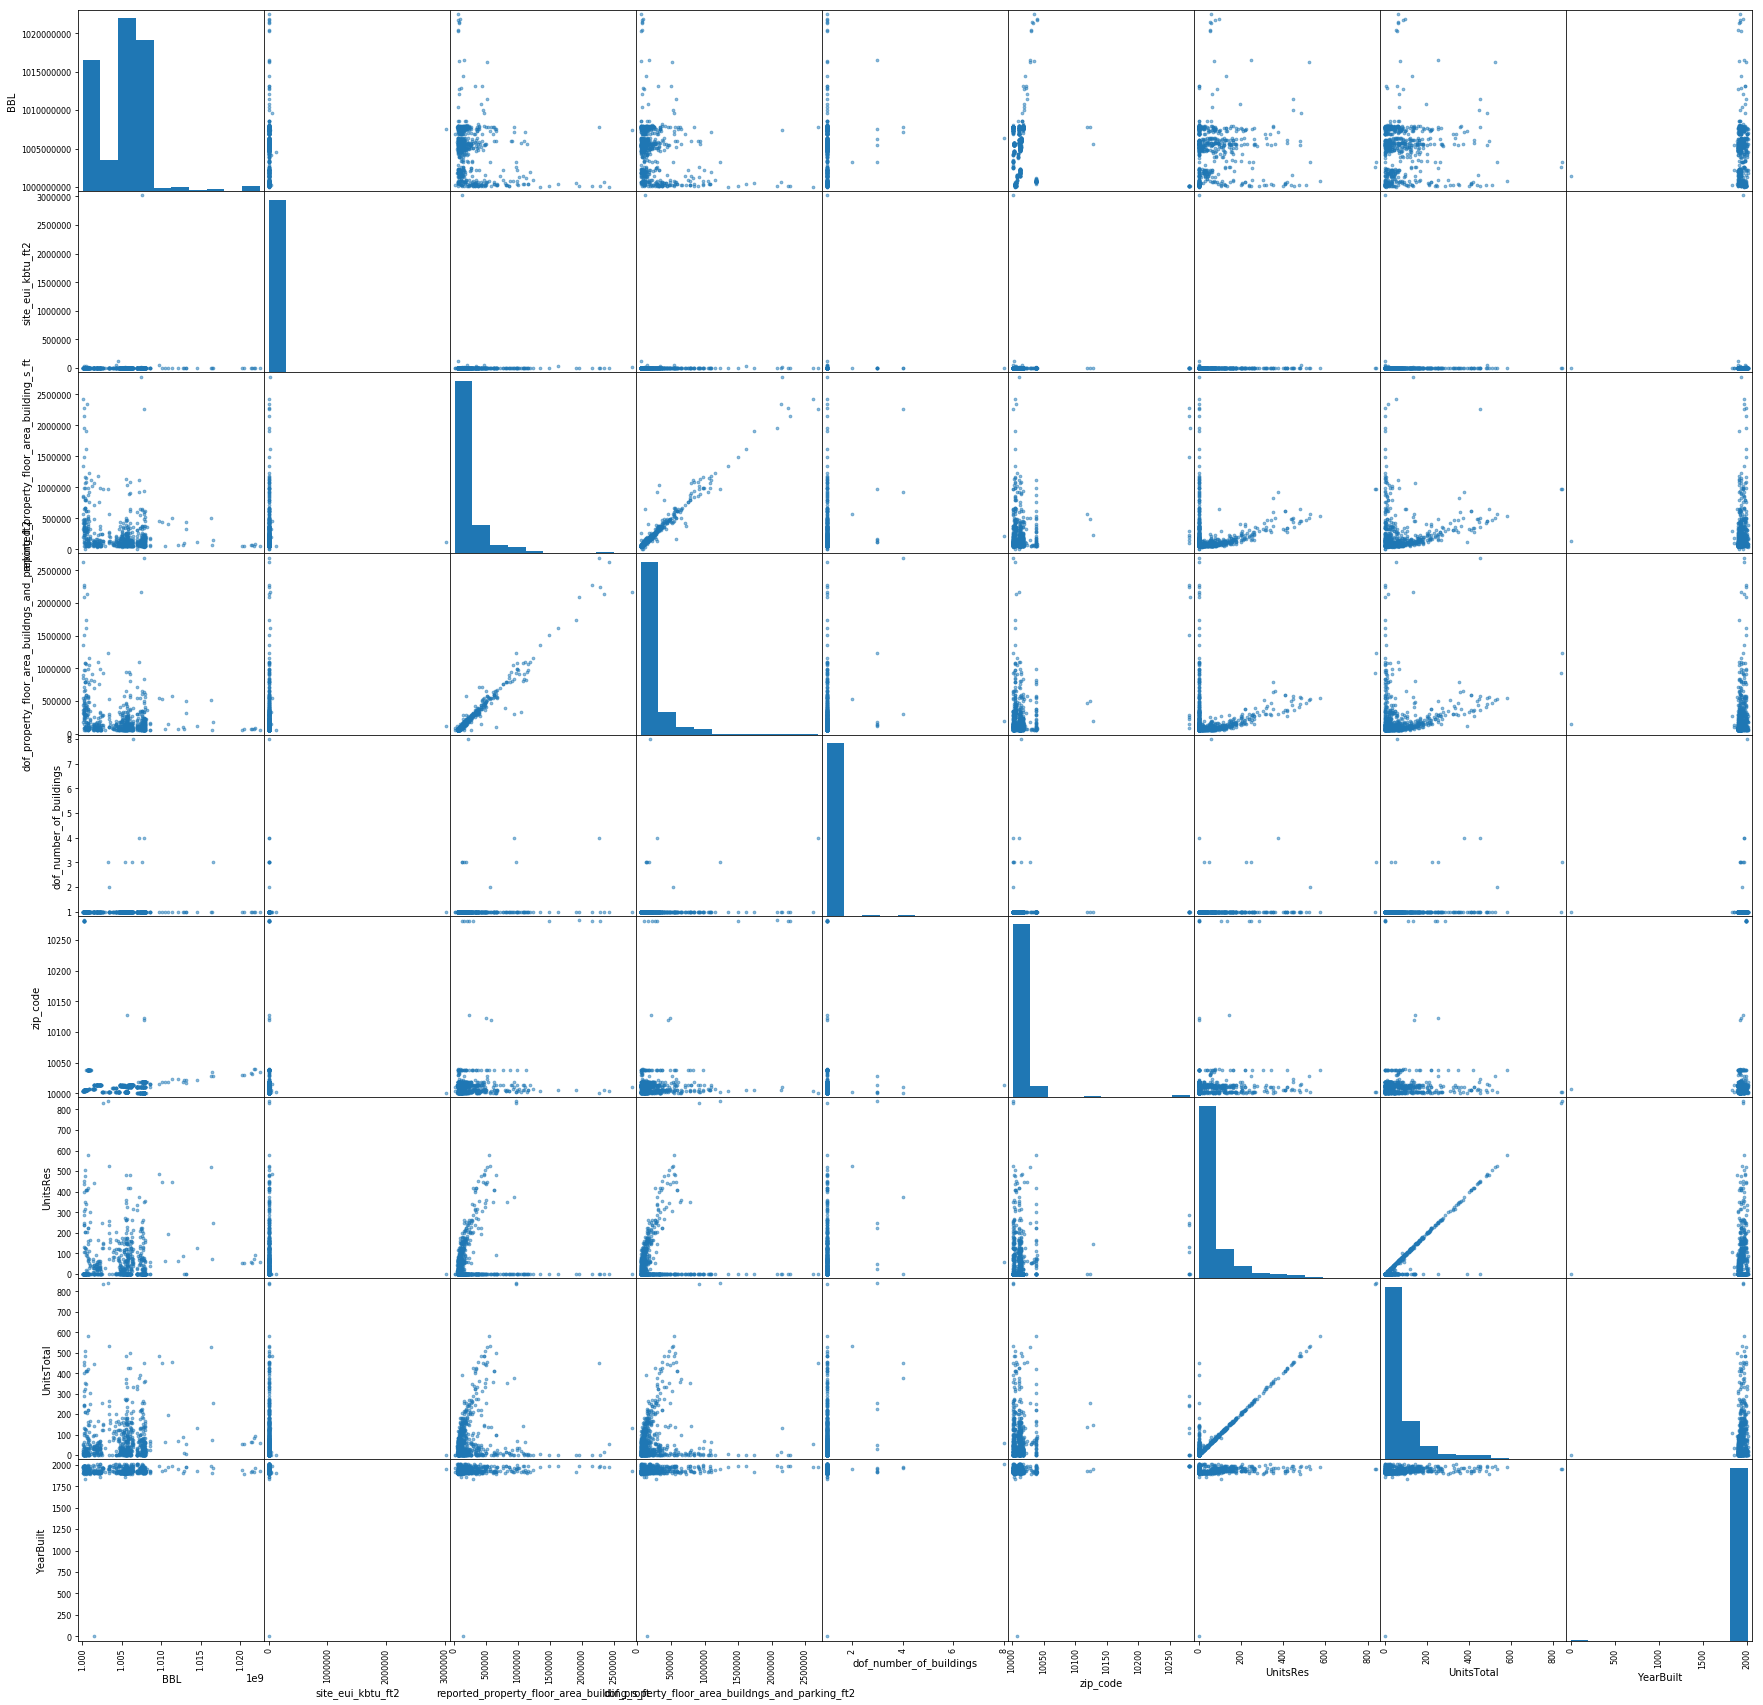

In [21]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(30,30));

Figure 2: The above figure is scatter matrix of final dataset, after merging. A lot of the plots are clustered in the bottom left corner, with some outliers. Some of the graphs shows a exponential relationship, which could become linear, if the data was plotted on a logarithmic scale.
 

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [22]:
# first scatter plot
#calculating energy consumption
bblnrgdata['Energy'] = bblnrgdata.site_eui_kbtu_ft2 * bblnrgdata.reported_property_floor_area_building_s_ft
bblnrgdata.head()

,BBL,site_eui_kbtu_ft2,reported_property_floor_area_building_s_ft,dof_property_floor_area_buildngs_and_parking_ft2,dof_number_of_buildings,zip_code,UnitsRes,UnitsTotal,YearBuilt,Energy
2,1.013110e+09,125.4,330000.0,313200.0,1.0,10022.0,0,56,1977,41382000.0
15,1.007660e+09,122.3,59468.0,53168.0,1.0,10011.0,0,8,1912,7272936.4
16,1.008150e+09,117.0,364000.0,364000.0,1.0,10018.0,0,24,1954,42588000.0
18,1.005050e+09,82.1,235370.0,214110.0,1.0,10013.0,0,24,1926,19323877.0
19,1.021420e+09,137.7,64806.0,64816.0,1.0,10032.0,54,62,1924,8923786.2


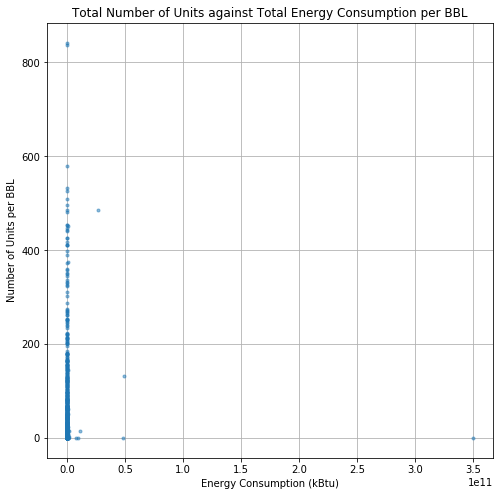

In [23]:
#plotting total number of units against total energy consumption per BBL. I drew this graph according to the graph on the professors' notebook.
#however I feel it is not an appropriate way of representing the total energy consumption per BBL. I think that the axes need to be reversed.
#This is further clarified through the regression model discussed later in the notebook.
fig = pl.figure(figsize(8,8))
ax = fig.add_subplot(111)
ax.plot(bblnrgdata.Energy, bblnrgdata.UnitsTotal, '.', alpha=0.5)
ax.set_title('Total Number of Units against Total Energy Consumption per BBL')
ax.set_xlabel('Energy Consumption (kBtu)')
ax.set_ylabel('Number of Units per BBL');
ax.grid()

Figure 3:  The above plot shows number of Units per BBL against Energy Consumption (kBtu).

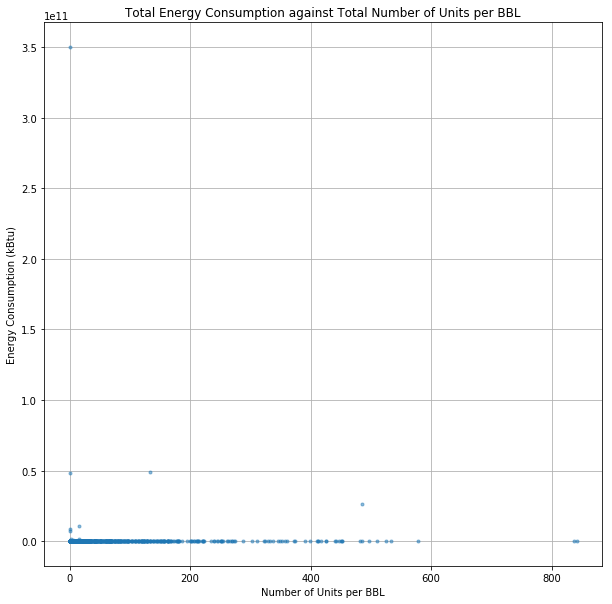

In [24]:
#plotting total number of units against total energy consumption per BBL. I inversed the axes and re-drew the graphs.
fig = pl.figure(figsize(10,10))
ax = fig.add_subplot(111)
ax.plot(bblnrgdata.UnitsTotal,bblnrgdata.Energy,'.', alpha=0.5)
ax.set_title('Total Energy Consumption against Total Number of Units per BBL')
ax.set_ylabel('Energy Consumption (kBtu)')
ax.set_xlabel('Number of Units per BBL');
ax.grid()

Figure 4:  The above plot shows total Energy Consumption (kBtu) against Number of Units per BBL. The plot doesn't depict the data well. There are many points with 0 energy consumption, even though the number of Units per BBL is increasing. This is probably because of data entry error and will be filtered later. The zoomed in plot will give a clear depiction of the data.

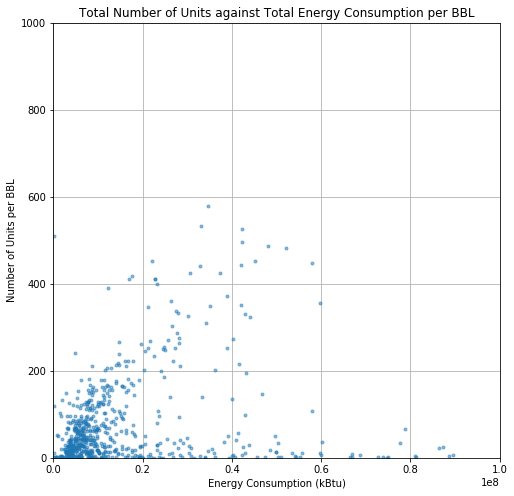

In [25]:
#Again this is what the professor plotted out in her template file, but I think that the axes needs to be reversed.
# zoomed in scatter plot
fig = pl.figure(figsize(8,8))
ax = fig.add_subplot(111)
ax.plot(bblnrgdata.Energy, bblnrgdata.UnitsTotal, '.', alpha=0.5)
ax.set_xlim(1000,1e8)
ax.set_ylim(0,1000)
ax.set_title('Total Number of Units against Total Energy Consumption per BBL')
ax.set_xlabel('Energy Consumption (kBtu)')
ax.set_ylabel('Number of Units per BBL')
ax.grid()

Figure 5: This plot is the same data as Figure 3, zoomed in to study the data subset of interest.

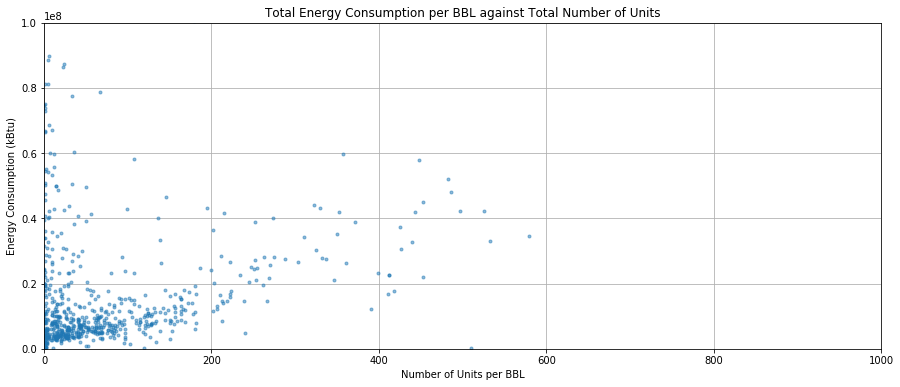

In [26]:
#I re-plotted the zoomed in graph based on Figure 4, after reversing the axes.
# zoomed in scatter plot
fig = pl.figure(figsize(15,6))
ax = fig.add_subplot(111)
ax.plot(bblnrgdata.UnitsTotal, bblnrgdata.Energy, '.', alpha=0.5)
ax.set_ylim(1000,1e8)
ax.set_xlim(0,1000)
ax.set_title('Total Energy Consumption per BBL against Total Number of Units')
ax.set_ylabel('Energy Consumption (kBtu)')
ax.set_xlabel('Number of Units per BBL')
ax.grid()

Figure 6: This plot is the same data as Figure 4, zoomed in to study data subset of interest. The zoomed in plot makes it easy to study the relationship between Energy Consumption and Numbe of Units per BBL. The plot shows there is a exponential relationsip between the variables. However most of the data is clustered at lower magnitudes of energy consumption and quite sparse at higher magnitudes.

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **
**try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and expand the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. You can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000] - see below.

Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of "LEVERAGE", however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work, but that should be stated clearly in your report.


In [27]:
#you may need to change the name of this column under some versions of pandas
#(ft²) may throw an error due to the funny character depending on encoding
#bblnrgdata['Reported Property Floor Area (Building(s))'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft2)']

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


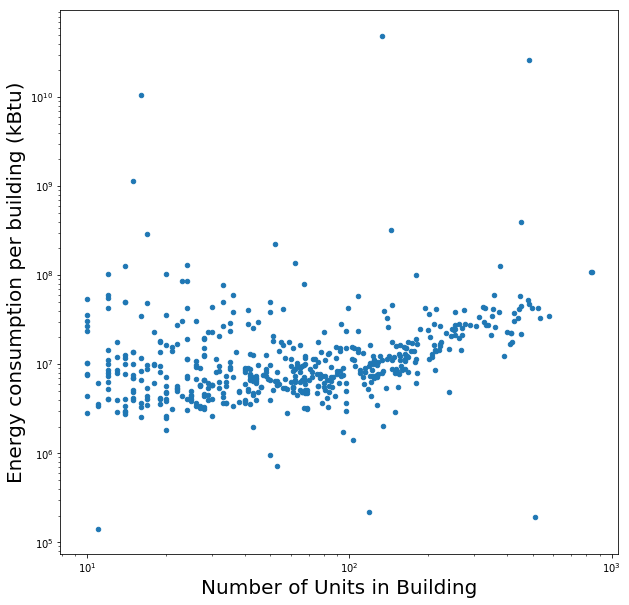

In [28]:
# I have the energy per sq foot in the data, I need the total energy though
#bblnrgdata['nrg'] = ...

bblnrgdataCut = bblnrgdata[(bblnrgdata.Energy > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='Energy', x='UnitsTotal', 
                   marker='o',  figsize=(10, 10), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

Figure 7: The plot is based on the data shown in Figure 6. Here the data is displayed on a logarithmic scale to show the exponential relationship in the variables in linear form. The variables appears to have a linear relationship after taking the log. The noise in the neighbourhood seems to be moderately normally distributed.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 


1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



In [29]:
len(bblnrgdataCut)

531

In [30]:
#Doing Regression to fit a line for number of units in Building as a function of energy consumption
x = bblnrgdataCut.Energy
y1 = bblnrgdataCut.Energy

y = bblnrgdataCut.UnitsTotal
x1 = bblnrgdataCut.UnitsTotal


X = sm.add_constant(np.log10(x))
X1 = sm.add_constant(np.log10(x1))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     39.39
Date:                Sun, 26 Nov 2017   Prob (F-statistic):           7.24e-10
Time:                        14:56:09   Log-Likelihood:                -300.95
No. Observations:                 531   AIC:                             605.9
Df Residuals:                     529   BIC:                             614.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0986      0.268      0.368      0.713        -0.427     0.624
Energy         0.2382      0.038      6.276      0.000         0.164     0.313
==============================================================================
Omnibus:                       16.327   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.561
Skew:                          -0.086   Prob(JB):                       0.0138
Kurtosis:                       2.402   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

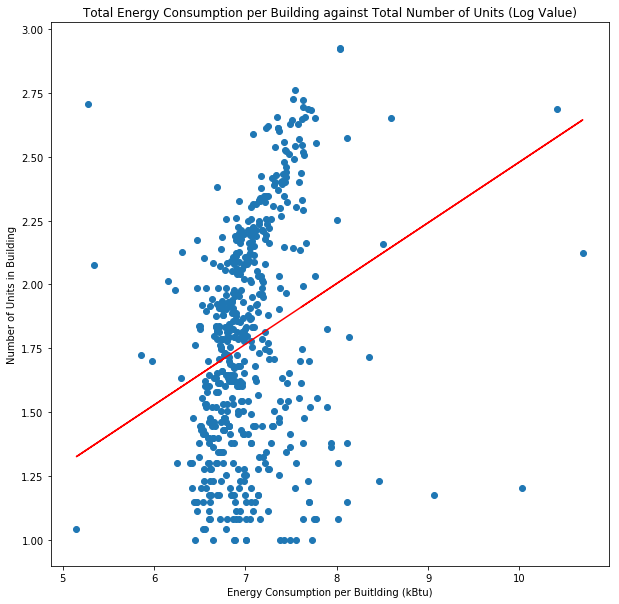

In [31]:
#Fitting a line for Unit vs Energy
fig = pl.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(x), np.log10(y))
ax1.plot(np.log10(x), linmodel.predict(sm.add_constant(X)), color = "red")
ax1.set_xlabel("Energy Consumption per Buitlding (kBtu)")
ax1.set_ylabel("Number of Units in Building")
ax1.set_title("Total Energy Consumption per Building against Total Number of Units (Log Value)");

Figure 8: The plot shows the total number of units in a building as a function of its energy consumption. It can be seen that the model does not provide an accurate mapping between the two variables, as the line doesnt fit the dataset well.

In [32]:
#Running another regression model where dependent variable is the 'Energy'
linmodel1 = sm.OLS(np.log10(y1), X1, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
linmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     39.39
Date:                Sun, 26 Nov 2017   Prob (F-statistic):           7.24e-10
Time:                        14:56:09   Log-Likelihood:                -354.14
No. Observations:                 531   AIC:                             712.3
Df Residuals:                     529   BIC:                             720.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.5209      0.085     76.908      0.000         6.354     6.688
UnitsTotal     0.2910      0.046      6.276      0.000         0.200     0.382
==============================================================================
Omnibus:                      309.655   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5052.767
Skew:                           2.203   Prob(JB):                         0.00
Kurtosis:                      17.455   Cond. No.                         9.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

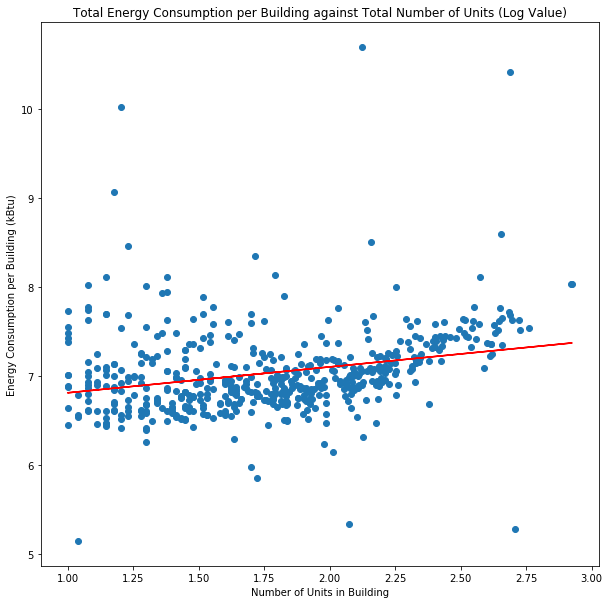

In [33]:
#Fitting a line for Energy vs Unit
fig = pl.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(x1), np.log10(y1))
ax1.plot(np.log10(x1), linmodel1.fittedvalues, color = "red")
ax1.set_ylabel("Energy Consumption per Building (kBtu)")
ax1.set_xlabel("Number of Units in Building")
ax1.set_title("Total Energy Consumption per Building against Total Number of Units (Log Value)");

Figure 9: The plot shows the energy consumption as a function of its total number of units in a building . It can be seen that the model provides an accurate mapping between the two variables, as the line fits the dataset well.

In [34]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [35]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['reported_property_floor_area_building_s_ft'])**2 +\
                (bblnrgdataCut['site_eui_kbtu_ft2']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log


propagation of errors on the log:https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [36]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.Energy / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
chi2(log(x), linmodel.fittedvalues, errors = errorsInLogNrg)

11007654000356.979

In [38]:
chi2(log(x1), linmodel1.fittedvalues, errors = errorsInLogUnits)

1393237.896812629

Chi Squared Results :
The chi squared statistic shows that the model that gives energy as a function of total units performs better and fits the data better than the inverse.

Can we do a log likelihood test between the two models?
No because they are different models and neither model contains the other.

Why were the errors calculated like they were?

The variable Energy Consumption is actually calculated based on a combination of two other variables, Reported Property Floor Area and Site EUI. Because Energy Consumption wasn't actually measured, the errors come from its constituent parts- from the metadata. The total area was found by taking the magnitude of the error vector. Because the regression was performed in log space, the errors needed to be transformed into log space as well. The formula to do that is given above.

In [39]:
linmodel_poly = smf.ols('energy ~ units + I(units**2)', data = pd.DataFrame({'energy':np.log10(y1),'units':np.log10(x1)})).fit() 
linmodel_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     45.72
Date:                Sun, 26 Nov 2017   Prob (F-statistic):           4.88e-19
Time:                        14:56:10   Log-Likelihood:                -330.80
No. Observations:                 531   AIC:                             667.6
Df Residuals:                     528   BIC:                             680.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         8.5105      0.297     28.657      0.000         7.927     9.094
units            -2.0330      0.337     -6.040      0.000        -2.694    -1.372
I(units ** 2)     0.6382      0.092      6.965      0.000         0.458     0.818
==============================================================================
Omnibus:                      305.256   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6394.160
Skew:                           2.068   Prob(JB):                         0.00
Kurtosis:                      19.489   Cond. No.                         98.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

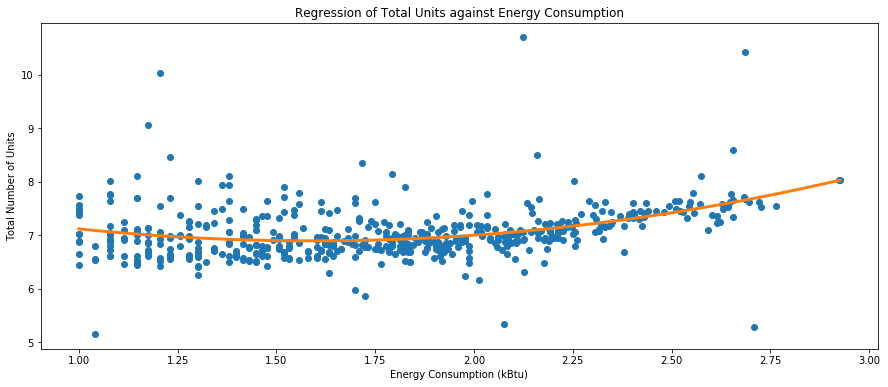

In [40]:
poly_x = np.linspace(np.log10(x1).min(), np.log10(x1).max(), 100)
pl.plot(np.log10(x1), np.log10(y1), 'o')
pl.plot(poly_x, linmodel_poly.predict({'units': poly_x}), linewidth=3)
pl.title('Regression of Total Units against Energy Consumption')
pl.xlabel('Energy Consumption (kBtu)')
pl.ylabel('Total Number of Units');

Figure 10: The above figure shows the polynomial regression over the dataset. The polynomial regression appears to be a better fit visually than the linear regression. The model has a higher adjusted R^2 value. 

In [41]:
print ("LR : ", -2 * (linmodel.llf - (linmodel_poly.llf)))
print ("LR from statsmodels:", linmodel_poly.compare_lr_test(linmodel)[0])

LR :  -59.7168507015
LR from statsmodels: -59.7168507015


Null Hypothesis: The polynomial regression is not a better fit than the linear regression.
The log likelihood ratio statistics calculated by hand and by statsmodels are same, thus validating the result. The critical chi squared value for models with a difference of 1 degree of freedom for a confidence interval of 95% is 3.84. The LR statistic is larger than the critical value of 3.84, thus the null hypothesis can be rejected. Further it confirms the findings in the Figure 10.


## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

## ASH - SCORE 100. Extra Credit not attempted